<a href="https://colab.research.google.com/github/ZaichenkoNA/Stat_Prac/blob/main/Dz4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем необходимые библиотеки и считаем датасет

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("./drive/MyDrive/flights.csv", low_memory=False)
airlines = pd.read_csv("./drive/MyDrive/airlines.csv", low_memory=False)
df.info()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHED

In [154]:
airlines.head(15)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [155]:
df.isna().sum()

,0
YEAR,0
MONTH,0
DAY,0
DAY_OF_WEEK,0
AIRLINE,0
FLIGHT_NUMBER,0
TAIL_NUMBER,14721
ORIGIN_AIRPORT,0
DESTINATION_AIRPORT,0
SCHEDULED_DEPARTURE,0


Почистим датасет от лишних аэропортов:

In [166]:
df = df[(df["ORIGIN_AIRPORT"].apply(str).apply(len) == 3) & (df["DESTINATION_AIRPORT"].apply(str).apply(len) == 3)]

Посчитаем среднее время задержки у каждой авикомпании.

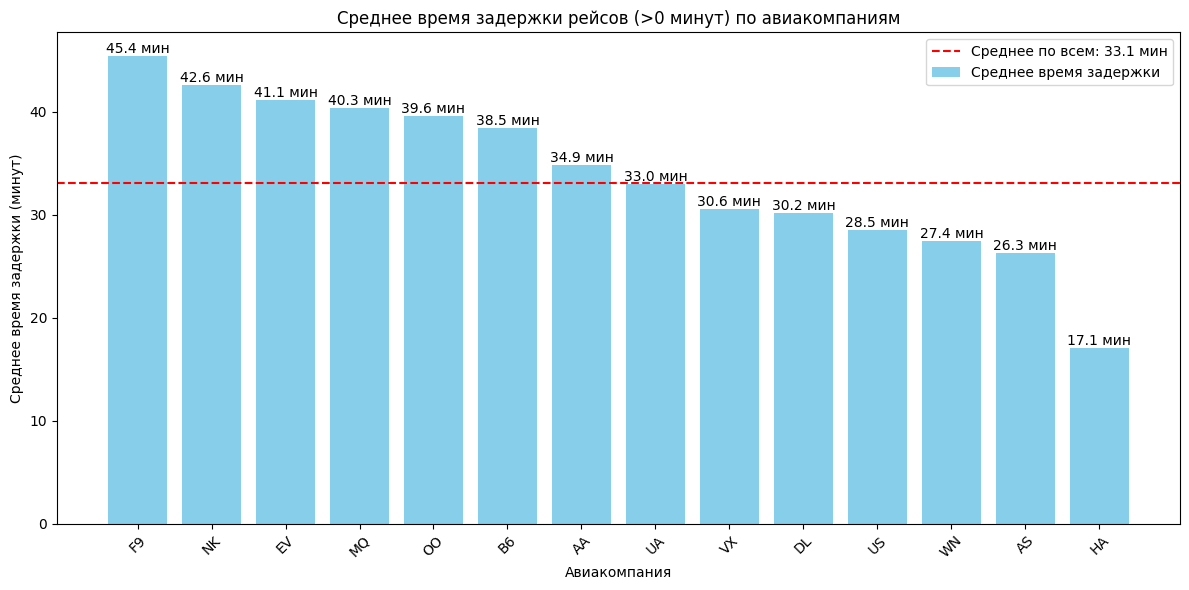

In [158]:
delayed_flights = df[df['DEPARTURE_DELAY'] > 0]
avg_delays = delayed_flights.groupby('AIRLINE')['DEPARTURE_DELAY'].mean().reset_index()
avg_delays = avg_delays.sort_values('DEPARTURE_DELAY', ascending=False)
overall_avg = delayed_flights['DEPARTURE_DELAY'].mean()


plt.figure(figsize=(12, 6))
bars = plt.bar(avg_delays['AIRLINE'], avg_delays['DEPARTURE_DELAY'],
               color='skyblue', label='Среднее время задержки')
plt.axhline(y=overall_avg, color='red', linestyle='--',
            label=f'Среднее по всем: {overall_avg:.1f} мин')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f} мин', ha='center', va='bottom')
plt.title('Среднее время задержки рейсов (>0 минут) по авиакомпаниям')
plt.xlabel('Авиакомпания')
plt.ylabel('Среднее время задержки (минут)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Проблема 1: Среднее время задержки превышает полчаса. У четырёх авиакомпаний (Frontier Airlines Inc., Spirit Air Lines, Atlantic Southeast Airlines, American Eagle Airlines Inc.) среднее время задержки превышает 40 минут.

Теперь посмотрим на аэропорты с большим количеством задержек. Также посмотрим на количество вылетов из этих аэропортов, чтобы предположить, может ли влиять их загруженность на количество задержек.

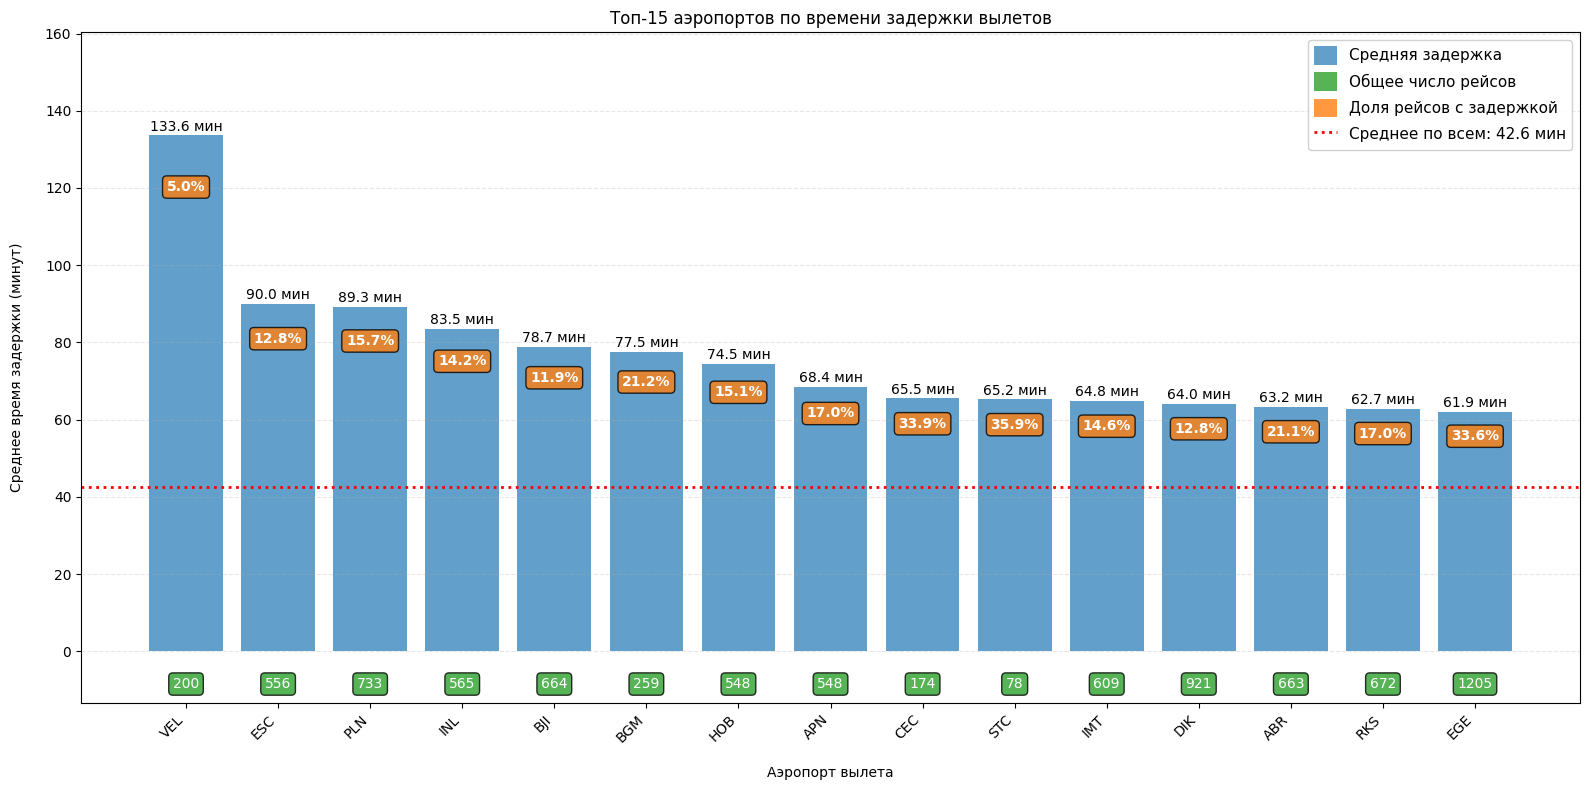

In [159]:

all_airports_stats = df.groupby('ORIGIN_AIRPORT').agg(
    total_flights=('DEPARTURE_DELAY', 'count'),
    delayed_flights=('DEPARTURE_DELAY', lambda x: (x > 0).sum()),
    avg_delay=('DEPARTURE_DELAY', lambda x: x[x > 0].mean())
).sort_values('avg_delay', ascending=False)

top_airports = all_airports_stats.head(15)

plt.figure(figsize=(16, 8))
ax = plt.gca()
bar_color = '#1f77b4'
total_color = '#2ca02c'
ratio_color = '#ff7f0e'

bars = ax.bar(top_airports.index, top_airports['avg_delay'],
              color=bar_color, alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
            f'{height:.1f} мин', ha='center', va='bottom',
            color='black', fontsize=10)

# Подписи общего числа рейсов
for i, (airport, row) in enumerate(top_airports.iterrows()):
    ax.text(i, -max(top_airports['avg_delay'])*0.05,
            f"{int(row['total_flights'])}",
            ha='center', va='top', color='white',
            bbox=dict(facecolor=total_color, alpha=0.8, boxstyle='round,pad=0.3'))

# Подписи доли задержек
for i, (airport, row) in enumerate(top_airports.iterrows()):
    ratio = row['delayed_flights'] / row['total_flights'] * 100
    ax.text(i, row['avg_delay'] * 0.9, f"{ratio:.1f}%",
            ha='center', va='center', color='white', fontweight='bold',
            bbox=dict(facecolor=ratio_color, alpha=0.8, boxstyle='round,pad=0.3'))

ax.axhline(overall_avg_delay, color='red', linestyle=':', linewidth=2)

plt.title('Топ-15 аэропортов по времени задержки вылетов')
plt.xlabel('Аэропорт вылета', labelpad=15)
plt.ylabel('Среднее время задержки (минут)', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.ylim(-max(top_airports['avg_delay'])*0.1, max(top_airports['avg_delay'])*1.2)

legend_elements = [
    plt.Rectangle((0,0), 1, 1, fc=bar_color, alpha=0.7, label='Средняя задержка'),
    plt.Rectangle((0,0), 1, 1, fc=total_color, alpha=0.8, label='Общее число рейсов'),
    plt.Rectangle((0,0), 1, 1, fc=ratio_color, alpha=0.8, label='Доля рейсов с задержкой'),
    plt.Line2D([0], [0], color='red', linestyle=':', linewidth=2,
              label=f'Среднее по всем: {overall_avg_delay:.1f} мин'),
]

ax.legend(handles=legend_elements,
          loc='upper right',
          framealpha=0.9,
          fontsize=11,
          handlelength=1.5,
          handleheight=1.5)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Проблема 2: У перечисленных выше аэропортов среднее время задержки превышает 1 час.

Посмотрим на среднюю задержку по месяцам

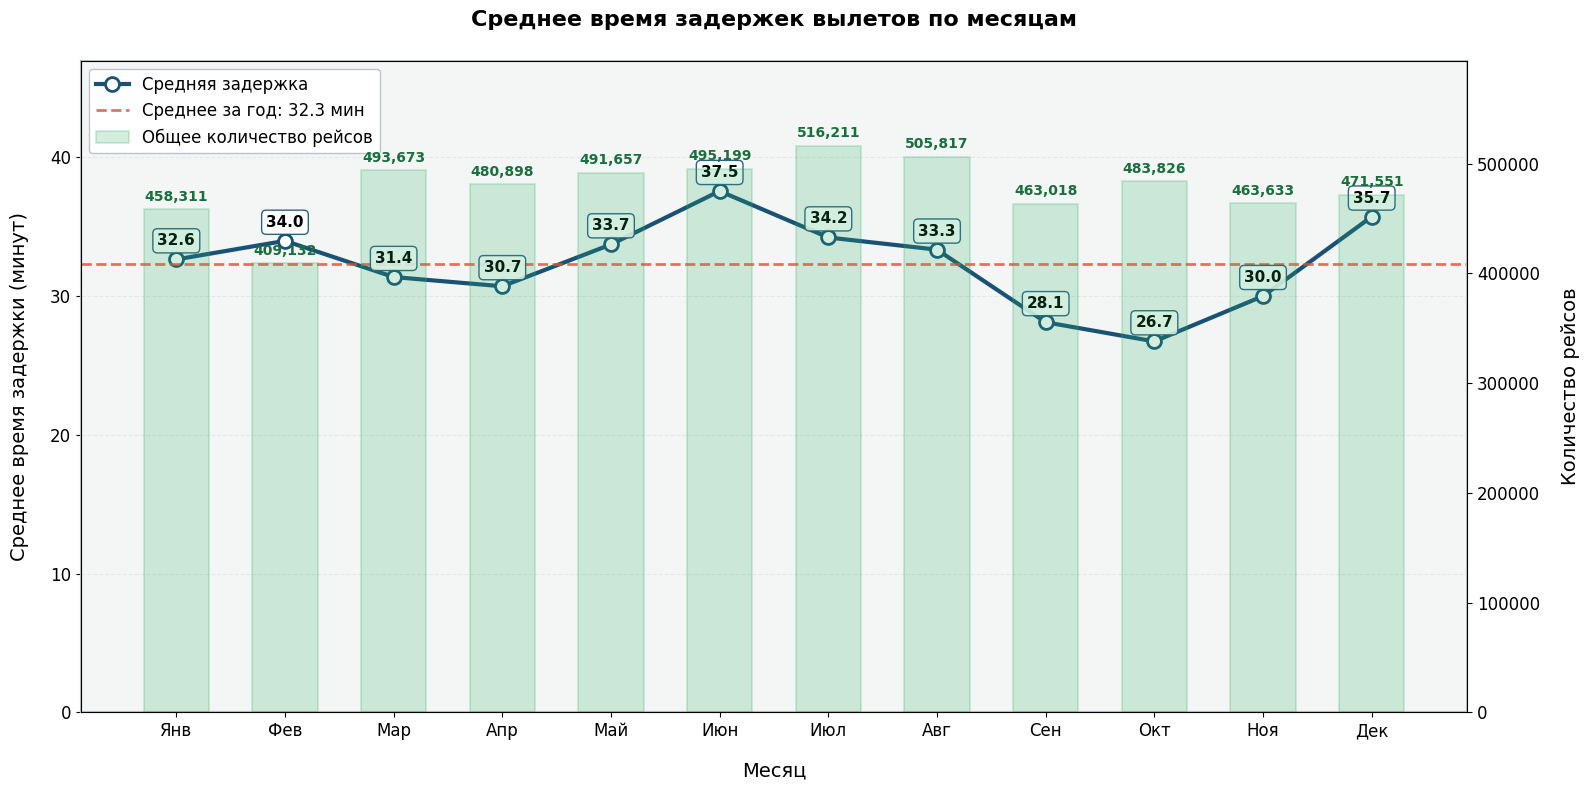

In [164]:

monthly_stats = df.groupby('MONTH').agg(
    total_flights=('DEPARTURE_DELAY', 'count'),
    delayed_flights=('DEPARTURE_DELAY', lambda x: (x > 0).sum()),
    avg_delay=('DEPARTURE_DELAY', lambda x: x[x > 0].mean())
).reset_index()

plt.figure(figsize=(16, 8), facecolor='white')
ax1 = plt.gca()

line, = ax1.plot(monthly_stats['MONTH'], monthly_stats['avg_delay'],
                marker='o', color='#1a5276', linewidth=3, markersize=10,
                markerfacecolor='white', markeredgewidth=2,
                label='Средняя задержка')

for x, y in zip(monthly_stats['MONTH'], monthly_stats['avg_delay']):
    ax1.text(x, y + 0.8, f'{y:.1f}', ha='center', va='bottom',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#1a5276', alpha=0.9))

ax2 = ax1.twinx()
bars = ax2.bar(monthly_stats['MONTH'], monthly_stats['total_flights'],
               color='#27ae60', alpha=0.2, width=0.6, edgecolor='#27ae60', linewidth=1.5,
               label='Общее количество рейсов')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + max(monthly_stats['total_flights'])*0.01,
            f'{height:,}', ha='center', va='bottom',
            color='#196f3d', fontsize=10, fontweight='bold')

month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
               'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_names, fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax1.set_title('Среднее время задержек вылетов по месяцам',
             pad=25, fontsize=16, fontweight='bold')
ax1.set_xlabel('Месяц', fontsize=14, labelpad=15)
ax1.set_ylabel('Среднее время задержки (минут)', fontsize=14, labelpad=15)
ax2.set_ylabel('Количество рейсов', fontsize=14, labelpad=15)
ax2.tick_params(axis='y', labelsize=12)

avg_delay = monthly_stats['avg_delay'].mean()
mean_line = ax1.axhline(avg_delay, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8,
                       label=f'Среднее за год: {avg_delay:.1f} мин')

lines = [line, mean_line, bars]
labels = [line.get_label(), mean_line.get_label(), bars.get_label()]
ax1.legend(lines, labels, loc='upper left', fontsize=12,
          frameon=True, framealpha=1, edgecolor='#bdc3c7')

ax1.grid(axis='y', linestyle='--', alpha=0.5, color='#d5dbdb')
ax1.set_facecolor('#f4f6f6')
ax1.set_ylim(0, max(monthly_stats['avg_delay']) * 1.25)
ax2.set_ylim(0, max(monthly_stats['total_flights']) * 1.15)

for spine in ax1.spines.values():
    spine.set_edgecolor('#bdc3c7')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

Проблема 3: В летние месяцы, а также в декабре средняя задержка увеличивается (особенно сильно в июне и декабре)

Проверим зависимость между количеством вылетов и количеством задержек

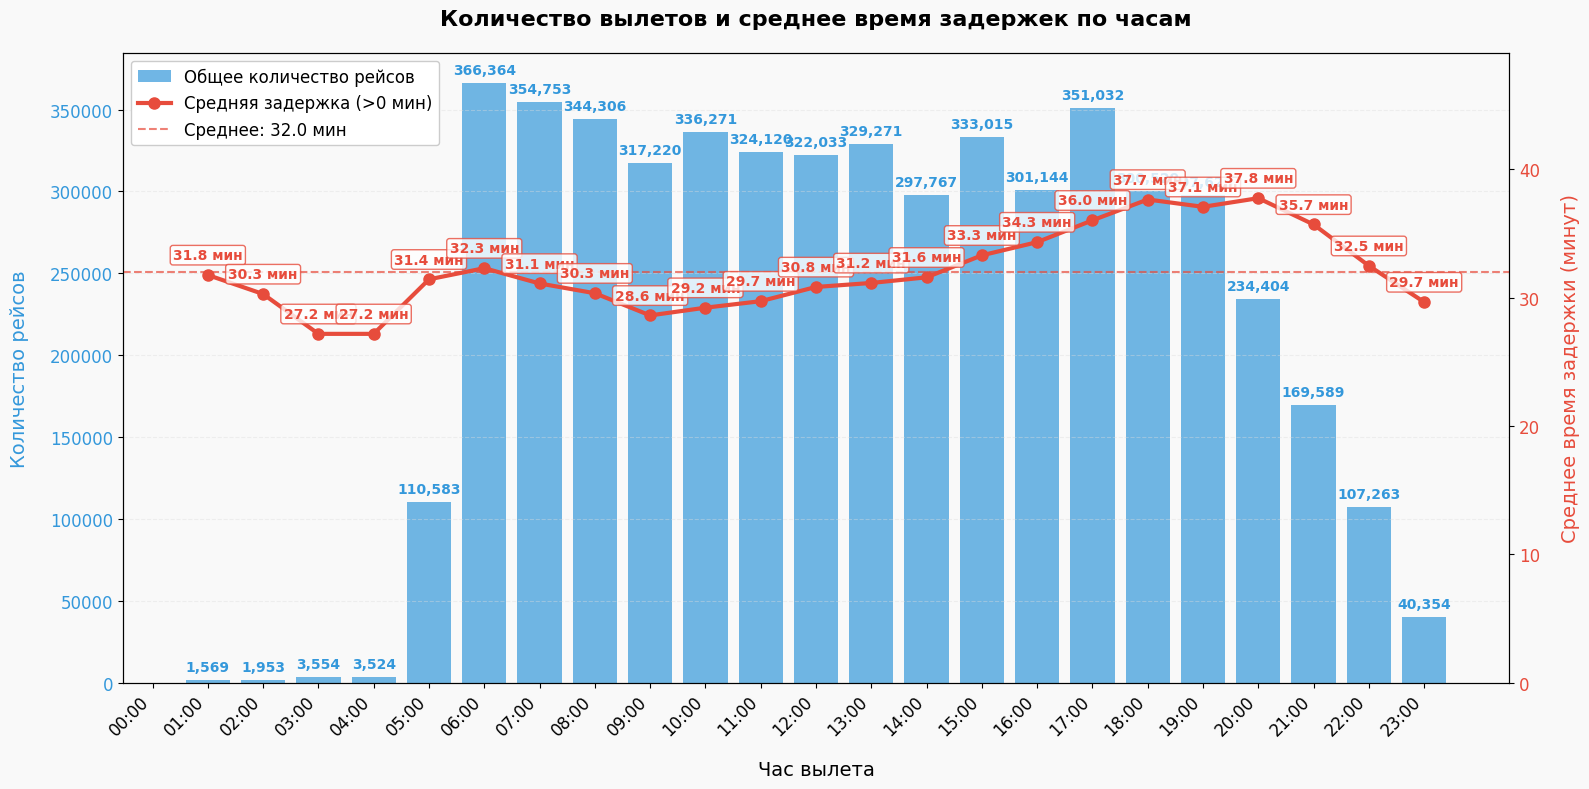

In [168]:

df['DEPARTURE_HOUR'] = pd.to_datetime(df['SCHEDULED_DEPARTURE'], format='%H%M', errors='coerce').dt.hour

hourly_stats = df.groupby('DEPARTURE_HOUR').agg(
    total_flights=('DEPARTURE_DELAY', 'count'),  #
    avg_delay=('DEPARTURE_DELAY', lambda x: x[x > 0].mean())
).reset_index()


fig, ax1 = plt.subplots(figsize=(16, 8))
plt.style.use('default')
flight_color = '#3498db'
delay_color = '#e74c3c'
bg_color = '#f9f9f9'

bars = ax1.bar(hourly_stats['DEPARTURE_HOUR'], hourly_stats['total_flights'],
               color=flight_color, alpha=0.7, width=0.8,
               label='Общее количество рейсов')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(hourly_stats['total_flights'])*0.01,
             f'{int(height):,}', ha='center', va='bottom',
             color=flight_color, fontsize=10, fontweight='bold')

ax1.set_xlabel('Час вылета', fontsize=14, labelpad=15)
ax1.set_ylabel('Количество рейсов', fontsize=14, labelpad=15, color=flight_color)
ax1.tick_params(axis='y', labelcolor=flight_color, labelsize=12)
ax1.set_xticks(range(0, 24))
ax1.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.4, color='#dddddd')

ax2 = ax1.twinx()
line = ax2.plot(hourly_stats['DEPARTURE_HOUR'], hourly_stats['avg_delay'],
                color=delay_color, marker='o', markersize=8, linewidth=3,
                label='Средняя задержка (>0 мин)')[0]

for x, y in zip(hourly_stats['DEPARTURE_HOUR'], hourly_stats['avg_delay']):
    if not np.isnan(y):
        ax2.text(x, y + 1, f'{y:.1f} мин', ha='center', va='bottom',
                color=delay_color, fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor=delay_color, alpha=0.8))

ax2.set_ylabel('Среднее время задержки (минут)', fontsize=14, labelpad=15, color=delay_color)
ax2.tick_params(axis='y', labelcolor=delay_color, labelsize=12)
ax2.set_ylim(0, max(hourly_stats['avg_delay'].dropna()) * 1.3 if not hourly_stats['avg_delay'].isna().all() else 10)

if not hourly_stats['avg_delay'].isna().all():
    avg_delay = hourly_stats['avg_delay'].mean()
    ax2.axhline(avg_delay, color=delay_color, linestyle='--', linewidth=1.5, alpha=0.7,
               label=f'Среднее: {avg_delay:.1f} мин')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
          loc='upper left', fontsize=12, framealpha=1)

plt.title('Количество вылетов и среднее время задержек по часам',
         fontsize=16, pad=20, fontweight='bold')
fig.set_facecolor(bg_color)
ax1.set_facecolor(bg_color)
plt.tight_layout()
plt.show()

Проблема 4: В вечернее время (с 16:00 до 22:00) возрастает среднее время задержки.

Посмотрим у каких авиакомпаний самое большое количество отмен рейсов

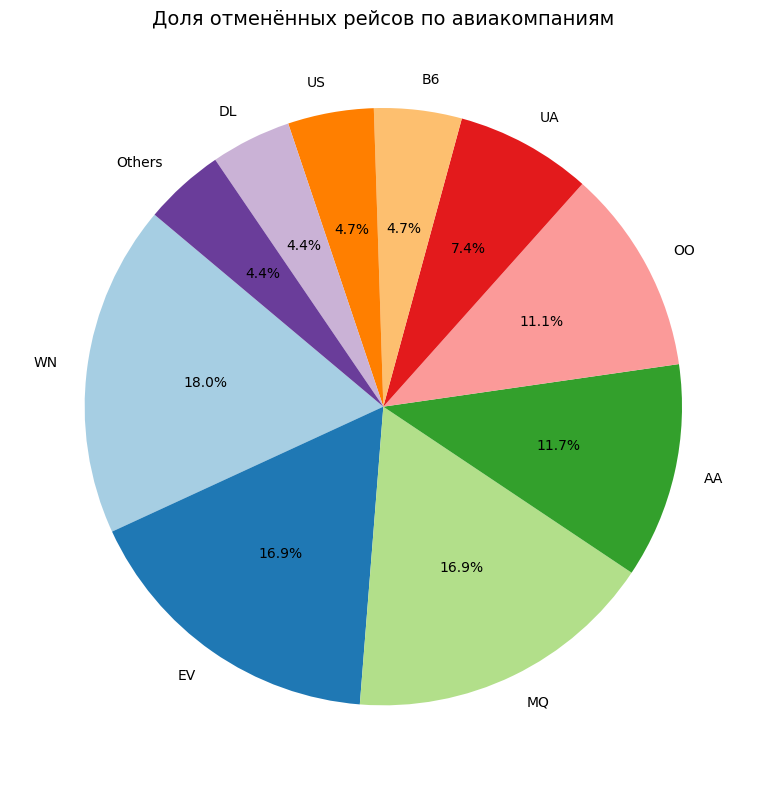

In [171]:

cancelled_flights = df[df['CANCELLED'] == 1]
cancelled_by_airline = cancelled_flights['AIRLINE'].value_counts()
total_cancelled = cancelled_by_airline.sum()
cancelled_by_airline_ratio = (cancelled_by_airline / total_cancelled) * 100

# Определяем порог для объединения
threshold = 4
others = cancelled_by_airline_ratio[cancelled_by_airline_ratio < threshold].sum()
filtered_data = cancelled_by_airline_ratio[cancelled_by_airline_ratio >= threshold]

filtered_data['Others'] = others
plt.figure(figsize=(10, 8))
plt.pie(filtered_data, labels=filtered_data.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Доля отменённых рейсов по авиакомпаниям', fontsize=14)
plt.tight_layout()
plt.show()

Проблема 5: Первые три авиакомпании по количеству отменённых рейсов (American Eagle Airlines Inc., Southwest Airlines Co., Atlantic Southeast Airlines) имеют больше половины отменённых рейсов от общего числа.